# Community Detection using sectors

## 1. load the required packages

In [2]:
import itertools
import operator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import networkx as nx
import networkx.algorithms.community as nxcom
from node2vec import Node2Vec

C:\Users\Danish\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [46]:
df = pd.read_excel('../data/all_submission_files2.xlsx')
data=df[df["report_end_date"].dt.year==2020]
info = pd.read_excel('../data/investees_info.xlsx')
info = info.set_index('ticker')

,zip,sector,fullTimeEmployees,longBusinessSummary,city,phone,state,country,companyOfficers,website,...,address2,fax,underlyingSymbol,underlyingExchangeSymbol,headSymbol,uuid,err,address3,averageMaturity,year_of_foundation
ticker,,,,,,,,,,,,,,,,,,,,,
SHW,44115-1075,Basic Materials,61031.0,"The Sherwin-Williams Company develops, manufac...",Cleveland,216 566 2000,OH,United States,[],http://www.sherwin-williams.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1866.0
AMZN,98109-5210,Consumer Cyclical,1271000.0,"Amazon.com, Inc. engages in the retail sale of...",Seattle,206-266-1000,WA,United States,[],http://www.amazon.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1994.0
AXDX,85714,Healthcare,224.0,"Accelerate Diagnostics, Inc., an in vitro diag...",Tucson,520 365 3100,AZ,United States,[],http://acceleratediagnostics.com,...,Suite 470 4th Floor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1982.0
NaN,60606,Financial Services,NaN,Nuveen New York Quality Municipal Income Fund ...,Chicago,312-917-7700,IL,United States,[],http://www.nuveen.com/CEF/Product/Overview.asp...,...,NaN,312-917-6912,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1999.0
HD,30339,Consumer Cyclical,504800.0,"The Home Depot, Inc. operates as a home improv...",Atlanta,770-433-8211,GA,United States,[],http://www.homedepot.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1978.0
PYPL,95131,Financial Services,26500.0,"PayPal Holdings, Inc. operates as a technology...",San Jose,408-967-1000,CA,United States,[],http://www.paypal.com,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998.0


In [107]:
#test = pd.merge(df,info, on="ticker", how="left")
test = df.join(info, on="ticker")
#df['ticker'].head(6)
#info.index.values.tolist()
test.shape

(46772, 143)

In [92]:
# Find all the possible CIK combinations (sorted) of length 2
all_cik_pairs = list(itertools.combinations(test['cik'].unique(), 2))

10296

In [170]:
def Amount_of_shared_sectors(L1,L2):
    L1 = L1.dropna()
    L1n = len(L1)
    L2 = L2.dropna()
    L2n = len(L2)
    shared_sec = 0
    for sector in L1:
        if sector in L2.values:
            loc = L2[L2 == sector].index[0]
            L2 = L2.drop(index=loc)
            shared_sec = shared_sec + 1
    if(L1n+L2n == 0):
        return 0
    else:
        return shared_sec*2/(L1n+L2n)


In [171]:
nodes_and_edges = []
for cik_pair in all_cik_pairs:
    df1 = test[test['cik']==cik_pair[0]]
    df2 = test[test['cik']==cik_pair[1]]
    nr_of_shared_sectors = Amount_of_shared_sectors(df1["sector"], df2["sector"])
    nodes_and_edges.append([cik_pair, nr_of_shared_sectors])

In [229]:
# Build a network of all CIK's.
# Add an edge between each CIK that invests in overlapping cusips, add weight +1 for each overlapping cusip
G=nx.Graph()
for (cik1, cik2), nr_of_shared_sectors in nodes_and_edges:
    if nr_of_shared_sectors == 0:
        pass
        # Don't add the nodes that are not connected, makes the graph impossible to understand
        # G.add_node(cik1)
        # G.add_node(cik2)
    elif nr_of_shared_sectors > 0.86:
        # Take a mimimum amount of shared cusips for visibility
        G.add_edge(cik1,cik2,weight=nr_of_shared_sectors)

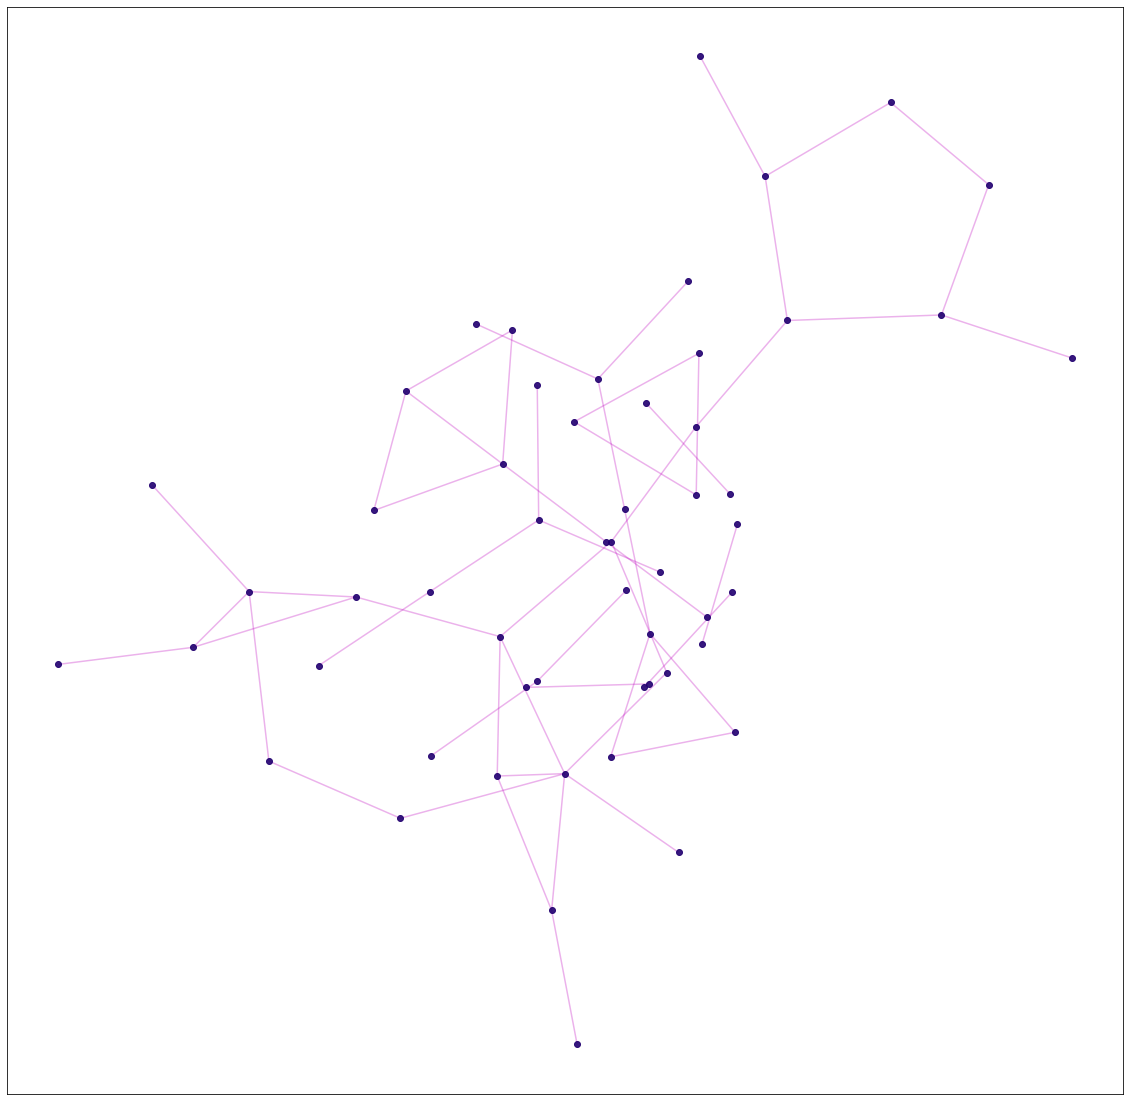

In [230]:
G.edges(data=True)
node_size =  None
edge_width = [w for _,w in nodes_and_edges]
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(20,20))
# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, width=None, edge_color="m")
nx.draw_networkx_nodes(G, pos, node_size=None, node_color="#210070", alpha=0.9)
label_options = {"ec": "k", "fc": "white", "alpha": 0.7}
# _ = nx.draw_networkx_labels(G, pos, font_size=14, bbox=label_options)

In [231]:
communities = sorted(nxcom.greedy_modularity_communities(G), key=len, reverse=True)
print(f"The group of investment funds has {len(communities)} communities.")

The group of investment funds has 12 communities.


In [232]:
# Helper functions to plot the graph with community labels
def set_node_community(G, communities):
    '''Add community to node attributes'''
    for c, v_c in enumerate(communities):
        for v in v_c:
            # Add 1 to save 0 for external edges
            G.nodes[v]['community'] = c + 1

def set_edge_community(G):
    '''Find internal edges and add their community to their attributes'''
    for v, w, in G.edges:
        if G.nodes[v]['community'] == G.nodes[w]['community']:
            # Internal edge, mark with community
            G.edges[v, w]['community'] = G.nodes[v]['community']
        else:
            # External edge, mark as 0
            G.edges[v, w]['community'] = 0

def get_color(i, r_off=1, g_off=1, b_off=1):
    '''Assign a color to a vertex.'''
    r0, g0, b0 = 0, 0, 0
    n = 16
    low, high = 0.1, 0.9
    span = high - low
    r = low + span * (((i + r_off) * 3) % n) / (n - 1)
    g = low + span * (((i + g_off) * 5) % n) / (n - 1)
    b = low + span * (((i + b_off) * 7) % n) / (n - 1)
    return (r, g, b)

In [233]:
# Set node and edge communities
set_node_community(G, communities)
set_edge_community(G)

node_color = [get_color(G.nodes[v]['community']) for v in G.nodes]

# Set community color for edges between members of the same community (internal) and intra-community edges (external)
external = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] == 0]
internal = [(v, w) for v, w in G.edges if G.edges[v, w]['community'] > 0]
internal_color = ['black' for e in internal]

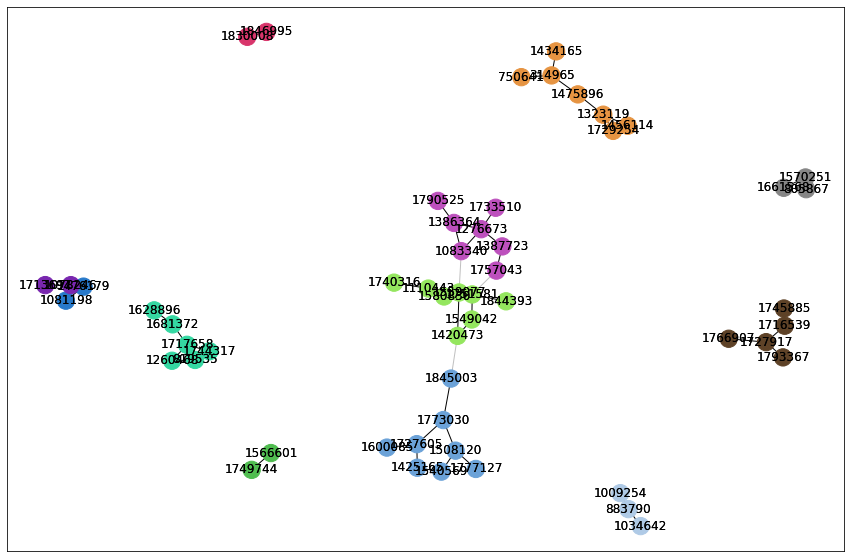

In [234]:
comm_pos = nx.spring_layout(G)

plt.rcParams.update({'figure.figsize': (15, 10)})
# Draw external edges
nx.draw_networkx(
    G,
    pos=comm_pos,
    node_size=0,
    edgelist=external,
    edge_color="silver")
# Draw nodes and internal edges
nx.draw_networkx(
    G,
    pos=comm_pos,
    node_color=node_color,
    edgelist=internal,
    edge_color=internal_color)